In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

In [2]:
df_test = pd.read_csv("/content/drive/My Drive/datasetTPDatos/test.csv")
df_train = pd.read_csv("/content/drive/My Drive/datasetTPDatos/train.csv")
#Elimino duplicados
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

In [3]:
#Definición de tipos
df_train['id'] = df_train['id'].astype(int)
df_train['keyword'] = df_train['keyword'].fillna(value = "noKeyword").astype('object')
df_train['location'] = df_train['location'].astype('object')
df_train['text'] = df_train['text'].astype('object')
df_train['target'] = df_train['target'].astype('bool')
df_test['id'] = df_test['id'].astype(int)
df_test['keyword'] = df_test['keyword'].fillna(value = "noKeyword").astype('object')
df_test['location'] = df_test['location'].astype('object')
df_test['text'] = df_test['text'].astype('object')

df_test.dtypes

id           int64
keyword     object
location    object
text        object
dtype: object

In [4]:
df_train_res = df_train.copy()
df_test_res = df_test.copy()

In [ ]:
#!pip install pycontractions
#from pycontractions import Contractions

In [ ]:
#cont = Contraction(api_key="glove-twitter-100")
#cont.load_models()

In [ ]:
#df_train_res['text'] = list(cont.expand_texts(df_train_cont['text'].to_list()))
#df_test_res['text'] = list(cont.expand_texts(df_test_cont['text'].to_list()))

In [5]:
def clean_text(text):
  text = re.sub('[=><.#,*;\']', '',text)
  text = re.sub('\n', '', text)
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('\w*\d\w*', '', text)
  text = re.sub('(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+/(?:[-\w.]|(?:%[\da-fA-F]{2}))+', 'URL',text)
  return text

In [6]:
from nltk.tokenize import TweetTokenizer

def pre_process_text(text):
  tokenizer = TweetTokenizer(reduce_len=True,strip_handles=False)
  processed_text = text.lower()
  processed_text = clean_text(processed_text)
  processed_text = tokenizer.tokenize(processed_text)
  processed_text = ' '.join(processed_text)
    
  return processed_text

In [7]:
#Pre limpieza:
df_train_res.head(5)

,id,keyword,location,text,target
0,1,noKeyword,NaN,Our Deeds are the Reason of this #earthquake M...,True
1,4,noKeyword,NaN,Forest fire near La Ronge Sask. Canada,True
2,5,noKeyword,NaN,All residents asked to 'shelter in place' are ...,True
3,6,noKeyword,NaN,"13,000 people receive #wildfires evacuation or...",True
4,7,noKeyword,NaN,Just got sent this photo from Ruby #Alaska as ...,True


In [8]:
df_train_res['text'] = df_train_res['text'].apply(lambda x : pre_process_text(x))
df_test_res['text'] = df_test_res['text'].apply(lambda x : pre_process_text(x))

In [9]:
#Post limpieza
df_train_res.head(5)

,id,keyword,location,text,target
0,1,noKeyword,NaN,our deeds are the reason of this earthquake ma...,True
1,4,noKeyword,NaN,forest fire near la ronge sask canada,True
2,5,noKeyword,NaN,all residents asked to shelter in place are be...,True
3,6,noKeyword,NaN,people receive wildfires evacuation orders in ...,True
4,7,noKeyword,NaN,just got sent this photo from ruby alaska as s...,True


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer()
x = tfidf_vec.fit_transform(df_train_res['text'])

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer()
x = tfidf_vec.fit_transform(df_train_res['text']).toarray()
score_arr = []
for tw in x:
  score = 0
  for w in tw:
    if w > 0:
      score += w
  score_arr.append(round(score,3))
print(score_arr)
print(len(score_arr))

[3.37, 2.574, 3.849, 2.513, 3.608, 3.704, 3.589, 3.201, 3.212, 2.952, 2.886, 3.796, 3.107, 2.04, 2.988, 1.703, 1.375, 1.644, 2.148, 1.343, 1.58, 1.654, 1.368, 1.679, 1.0, 2.335, 2.121, 1.644, 1.0, 1.863, 1.272, 2.187, 3.017, 3.042, 2.551, 3.451, 4.253, 2.517, 4.174, 1.895, 2.562, 2.702, 4.425, 2.135, 3.305, 3.481, 3.417, 2.874, 2.562, 4.556, 2.949, 3.122, 3.618, 3.028, 3.651, 3.787, 3.234, 3.948, 4.498, 3.765, 3.569, 3.802, 3.137, 4.121, 2.917, 2.686, 4.036, 4.25, 2.947, 3.806, 3.844, 3.7, 3.853, 1.948, 3.232, 3.165, 2.961, 2.606, 3.164, 3.158, 4.427, 3.953, 3.643, 3.566, 2.974, 3.677, 2.639, 4.666, 4.336, 2.609, 2.297, 2.02, 3.048, 3.017, 2.024, 3.485, 4.402, 4.027, 2.828, 3.535, 3.791, 4.144, 2.626, 3.868, 3.126, 3.159, 3.222, 2.693, 4.347, 2.785, 3.056, 3.086, 3.677, 1.322, 3.209, 3.222, 3.209, 2.671, 3.209, 3.209, 4.053, 3.688, 4.206, 2.192, 3.457, 3.495, 4.312, 3.596, 4.519, 3.158, 1.88, 1.54, 3.932, 3.975, 2.915, 3.274, 3.68, 3.999, 3.213, 3.738, 3.458, 4.044, 2.961, 2.87, 3.695,

In [28]:
#Lemmatization
!pip install -U textblob
!python -m textblob.download_corpora
from textblob import Word

def lematizar_texto(text):
  lem = []
  for i in text.split():
    word1 = Word(i).lemmatize("n")
    word2 = Word(word).lemmatize("v")
    word3 = Word(word2).lemmatize("a")
    lem.append(Word(word3)).lemmatize())
  lem_text = " ".join(lem)
  return lem_text

In [47]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
sw = stopwords.words("english")

tokenizer = TweetTokenizer(reduce_len=True,strip_handles=False)

false_words = []
true_words = []
for index,row in df_train_res.iterrows():
  clean_word = []
  dirty_words = tokenizer.tokenize(row['text'])
  for w in dirty_words:
    if w.isalpha() and w not in sw:
      clean_word.append(w.lower())
  if row['target'] == False:
    false_words += clean_word
  if row['target'] == True:
    true_words += clean_word  

false_freqs = FreqDist(false_words).most_common()
true_freqs = FreqDist(true_words).most_common()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# --------------- NLP - Manipulación  del texto --------------- #
#Idea 1 : Limpiar las stopwords y hacer un contador de entidades importantes (ej nombre paises, personas famosas, etc)

import spacy #Para Named Entity Recognition
from spacy import displacy #Para Named Entity Recognition
from collections import Counter #Para Named Entity Recognition
import en_core_web_sm #Para Named Entity Recognition
from nltk import word_tokenize
nltk.download('punkt')
sw = stopwords.words("english")
tknz = TweetTokenizer(reduce_len=True, strip_handles=False)
nlp = en_core_web_sm.load()
catastrophe = df_train_res['keyword'].loc[df_train_res['keyword'] != 'noKeyword'].drop_duplicates().apply(lambda x: re.sub('%20', ' ',x))

def contains_location(text):
  count = 0
  words = nlp(text)
  for X in words.ents:
    if X.label_ in ['FAC','GPE','LOC']:
      count += 1
  return count

def count_no_stopwords(text):
  count = 0
  words = word_tokenize(text)
  for w in words:
    if w not in sw:
      count +=1
  return count

def text_size_word(text):
  words = tknz.tokenize(text)
  return len(words)
  
def lemmatize_catastrophe(text):
  count = 0
  words = tknz.tokenize(text)
  for w in words:
    if w in catastrophe.to_list():
      count += 1
  return count/len(words)

def count_url_per_tw(text):
  count = 0
  words = tknz.tokenize(text)
  if 'URL' in words:
    for w in words:
      if w == 'URL':
        count +=1
  return count/len(words)

def score_true_freqs(text):
  score = 0
  words = tknz.tokenize(text)
  for w in words:
    for t in true_freqs:
      if w == t[0]:
        score += t[1]
  return score

def score_false_freqs(text):
  score = 0
  words = tknz.tokenize(text)
  for w in words:
    for t in false_freqs:
      if w == t[0]:
        score += t[1]
  return score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
#Me quedo con columnas que me interesan
df_train_res = df_train_res.loc[:,['id','text','target','keyword']]
df_test_res = df_test_res.loc[:,['id','text']]
df_train_res

,id,text,target,keyword
0,1,our deeds are the reason of this #earthquake m...,True,noKeyword
1,4,forest fire near la ronge sask canada,True,noKeyword
2,5,all residents asked to shelter in place are be...,True,noKeyword
3,6,people receive #wildfires evacuation orders in...,True,noKeyword
4,7,just got sent this photo from ruby #alaska as ...,True,noKeyword
...,...,...,...,...
7608,10869,two giant cranes holding a bridge collapse int...,True,noKeyword
7609,10870,@aria_ahrary @thetawniest the out of control w...,True,noKeyword
7610,10871,? s of volcano hawaii http://tco/,True,noKeyword
7611,10872,police investigating after an e-bike collided ...,True,noKeyword


In [12]:
# ---------------Creación de features --------------- #

# --------------------------------- Train ------------------------------------ #
df_train_res['count_words'] = df_train_res['text'].apply(text_size_word) #cant words por text
df_train_res['num_no_stopwords'] = df_train_res['text'].apply(count_no_stopwords)
df_train_res['no_stpw / count_words'] = df_train_res['num_no_stopwords'] / df_train_res['count_words']
df_train_res['count_catastrophe'] = df_train_res['text'].apply(lemmatize_catastrophe)
df_train_res['count_url'] = df_train_res['text'].apply(count_url_per_tw)
df_train_res['contains_location'] = df_train_res['text'].apply(contains_location)
# --- Idea 1 --- # Aplicar algun tipo de TF-IDF para descartar textos como "wreck wreck wreck wreck wreck " porque no aportan nada
# --- Idea 2 --- #  Top frecuencias para tweets verdaderos / falsos , darle un score a los tweets en base a esas frecuencias
df_train_res['score_true'] = df_train_res['text'].apply(score_true_freqs)
df_train_res['score_false'] = df_train_res['text'].apply(score_false_freqs)

In [34]:
df_train_res['score_true'] = df_train_res['text'].apply(score_true_freqs)
df_train_res['score_false'] = df_train_res['text'].apply(score_false_freqs)

In [ ]:
df_train_res['tfidf-sum'] = score_arr

In [13]:
df_train_res

,id,keyword,location,text,target,count_words,num_no_stopwords,no_stpw / count_words,count_catastrophe,count_url,contains_location,score_true,score_false
0,1,noKeyword,NaN,our deeds are the reason of this earthquake ma...,True,13,7,0.538462,0.076923,0.0,0,190,145
1,4,noKeyword,NaN,forest fire near la ronge sask canada,True,7,7,1.000000,0.142857,0.0,1,308,100
2,5,noKeyword,NaN,all residents asked to shelter in place are be...,True,22,11,0.500000,0.045455,0.0,0,116,52
3,6,noKeyword,NaN,people receive wildfires evacuation orders in ...,True,7,6,0.857143,0.142857,0.0,1,278,110
4,7,noKeyword,NaN,just got sent this photo from ruby alaska as s...,True,16,9,0.562500,0.062500,0.0,1,111,186
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,noKeyword,NaN,two giant cranes holding a bridge collapse int...,True,11,11,1.000000,0.090909,0.0,0,269,81
7609,10870,noKeyword,NaN,@aria_ahrary @thetawniest the out of control w...,True,20,13,0.650000,0.000000,0.0,1,377,133
7610,10871,noKeyword,NaN,? s of volcano hawaii http://tco/,True,6,6,1.000000,0.166667,0.0,0,33,7
7611,10872,noKeyword,NaN,police investigating after an e-bike collided ...,True,19,14,0.736842,0.157895,0.0,1,258,147


In [ ]:
# --------------------------------- Test ------------------------------------- #

df_test_res['count_words'] = df_test_res['text'].apply(text_size_word) #cant words por text
df_test_res['num_no_stopwords'] = df_test_res['text'].apply(count_no_stopwords)
df_test_res['no_stpw / count_words'] = df_test_res['num_no_stopwords'] / df_test_res['count_words']
df_test_res['count_catastrophe'] = df_test_res['text'].apply(lemmatize_catastrophe)
df_test_res['count_url'] = df_test_res['text'].apply(count_url_per_tw)
df_test_res['contains_location'] = df_test_res['text'].apply(contains_location)
# --- Idea 1 --- # Aplicar algun tipo de TF-IDF para descartar textos como "wreck wreck wreck wreck wreck " porque no aportan nada
# --- Idea 2 --- #  Top frecuencias para tweets verdaderos / falsos , darle un score a los tweets en base a esas frecuencias
df_test_res['score_true'] = df_test_res['text'].apply(score_true_freqs)
df_test_res['score_false'] = df_test_res['text'].apply(score_false_freqs)

In [15]:
feature_arr = ['count_words','num_no_stopwords','no_stpw / count_words','count_catastrophe','contains_location','count_url','score_true','score_false']

In [ ]:
df_test_res

In [ ]:
# -------------- Definición de train y test set - MLP (submit) --------------- #

y_train = np.array(df_train_res['target']) # prediction 
X_train = df_train_res.copy()  #Train submit
X_test = df_test_res.copy()
X_train_clf = X_train.loc[:,feature_arr] #Features del train
X_test_clf = X_test.loc[:,feature_arr] #Features del test
prints = (len(X_train_clf), len(y_train), len(X_test_clf))
print(prints) 

In [20]:
# --------------- Definición de train y test set local - MLP - (train spliteado en train2.0 y test porque no tengo target test) --------------- #

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
#X = np.array(X) #Esto se hace si tengo 1 solo feature
X = df_train_res.copy() #Train local
y = np.array(df_train_res['target']) # prediction 
X_train, X_test, y_train, y_test = train_test_split(X,y)
X_train_clf = X_train.loc[:,feature_arr] #Features del train
#X_train_clf = preprocessing.scale(X_train_clf) #Standarization, or mean removal and variance scaling para agilizar el entrenamiento pero me baja mucho el accuracy 
X_test_clf = X_test.loc[:,feature_arr] #Features del test
prints = (len(X_train) , len(X_test) , len(y_train) , len(y_test), y)
print(prints) 

(5709, 1904, 5709, 1904, array([ True,  True,  True, ...,  True,  True,  True]))


In [21]:
# --------------- Entrenamiento - MLP (Multilayer Perceptron) --------------- #
clf = MLPClassifier(activation='relu',learning_rate_init=0.0003, hidden_layer_sizes=(50,35,60), random_state=1, max_iter=400, solver='adam')
#X_train = X_train.reshape(-1, 1) #Esto se hace si tengo 1 solo feature
clf.fit(X_train_clf, y_train) 

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 35, 60), learning_rate='constant',
              learning_rate_init=0.0003, max_fun=15000, max_iter=400,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [22]:
# --------------- Prediccion y score - MLP --------------- #
pred = clf.predict(X_test_clf)

In [23]:
clf.score(X_test_clf,y_test)

0.8130252100840336

In [ ]:
def convertStates(x):
    if(x == True):
        return 1
    else:
        return 0

In [ ]:
from google.colab import files
predict = pd.DataFrame()
predict['id'] = X_test['id']
predict['target'] = pred
predict['target'] = predict['target'].apply(convertStates)
predict.to_csv('result.csv',index=False)
files.download('result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
# --------------- Comparación - Test vs Predict local - MLP --------------- #
result = X_test.loc[:,['id','text','target']]
result['prediction'] = pred
diff = result.loc[result['target'] != result['prediction']]
diff

,id,text,target,prediction
3441,4918,the dress memes have officially exploded on th...,True,False
6042,8637,england east coast dogger bank westward seismi...,False,True
3119,4479,do babies actually get electrocuted from wall ...,True,False
1193,1719,a marshall plan for the united states by dambi...,False,True
6837,9794,hollywood movie about trapped miners released ...,True,False
...,...,...,...,...
1954,2813,a new tropical cyclone is forming near guamonc...,True,False
5804,8285,the ashes test match is currently more interes...,True,False
502,727,kelly osbourne attacked for racist donald trum...,True,False
3479,4974,exploring new worlds : three moments of an exp...,True,False


In [ ]:
df_train_res.loc[5677,'text']

'Summer #summervibes #california #puppy #pitmix #rescued #brixton #banksy #happy #mybabies URL'

In [ ]:
df_train_res.iloc[7032]

id                                                                   10077
text                     Obama Declares Disaster for Typhoon-Devastated...
target                                                                True
keyword                                                            typhoon
count_words                                                              8
num_no_stopwords                                                         8
no_stpw / count_words                                                    1
count_catastrophe                                                        0
contains_location                                                        0
count_url                                                            0.125
Name: 7032, dtype: object

In [ ]:
diff.loc[diff['id'] == 10077]

,id,text,target,prediction


In [ ]:
df_train_res.iloc[2309]

id                                                              3317
text                     @_stiiilo i still got video of u demolished
target                                                         False
keyword                                                   demolished
count_words                                                        8
num_no_stopwords                                                   7
no_stpw / count_words                                          0.875
count_catastrophe                                                  1
contains_location                                                  1
count_url                                                          0
Name: 2309, dtype: object

In [ ]:
tknz.tokenize(df_train_res.loc[2309,'text'])

['@_stiiilo', 'i', 'still', 'got', 'video', 'of', 'u', 'demolished']

In [ ]:
diff.loc[diff['id'] == 3317]

,id,text,target,prediction
2309,3317,@_stiiilo i still got video of u demolished,False,True


In [ ]:
nlp = en_core_web_sm.load()
words = nlp(re.sub('#','','San Andres'))
print([(X.text, X.label_) for X in words.ents])

[('San Andres', 'ORG')]


In [ ]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-08-03 01:54:19--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.84.166
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.84.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  31.5MB/s    in 50s     

2020-08-03 01:55:10 (31.2 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
!pip install gensim
from gensim.models import KeyedVectors

In [ ]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
def cos(x1, x2):
  return np.dot(x1, x2)/(np.linalg.norm(x1)*np.linalg.norm(x2))

In [ ]:
#Jugando con word2vec
cos(word2vec[''],word2vec['pandemic'])
word2vec.most_similar(positive=['ruin'])

KeyError: ignored

In [ ]:
pred

In [ ]:
#--------- Prediccion-------
#pred = pd.DataFrame()
#pred['id'] = df_test['id']
#pred_data = model.predict(df_test_x)
#pred['target'] = pred_data.tolist()
#pred['target'] = pred['target'].apply(lambda x : convertStates(x))

In [30]:
#Random forest de rama
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
le = preprocessing.LabelEncoder()

#df_train["text"] = le.fit_transform(df_train['text'])
#df_train["target"] = le.fit_transform(df_train["target"])
classifier = RandomForestClassifier(n_estimators = 50, random_state = 0) 

classifier.fit(X_train_clf,y_train)

Y_pred = classifier.predict(X_test_clf)  # test the output by changing values 
print(Y_pred)

[ True  True False ... False  True False]


In [ ]:
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=400)
#tree.plot_tree(regressor.estimators_[0], feature_names = X_train_clf.columns, filled = True);

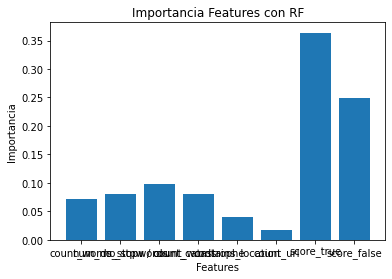

In [32]:
plt.bar(X_train_clf.columns, classifier.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con RF')
plt.show()

In [ ]:
X_train_clf.columns

Index(['count_words', 'num_no_stopwords', 'no_stpw / count_words',
       'count_catastrophe', 'contains_location', 'count_url', 'score_true',
       'score_false'],
      dtype='object')

In [ ]:
#csv de randomforest
from google.colab import files
pred = pd.DataFrame()
pred['id'] = X_test['id']
pred['target'] = Y_pred.tolist()
pred['target'] = pred['target'].apply(lambda x : round(x))
pred.to_csv('resultRFWF.csv',index=False)
files.download('resultRFWF.csv')